# Logistic Regression

In diesem Notebook erstellen wir eine `Baseline` mit Logistic Regression.
Wir verwenden dabei alle Features (Pixels) ohne Preprocessing (wie Dimensionsreduktion).

In [2]:
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

from sklearn.model_selection import train_test_split

import pickle

import matplotlib.pyplot as plt

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

import numpy as np

In [3]:
def plot_confusion_matrix(y_true: any, y_pred: any):
    labels = np.unique(y_true)
    fig = plt.figure(figsize=(len(labels), len(labels)))
    ConfusionMatrixDisplay(
      confusion_matrix=confusion_matrix(y_true=y_true, y_pred=y_pred, labels=labels, normalize='all'),
      display_labels=labels
    ).plot(ax=fig.gca(), cmap="BuPu", xticks_rotation='vertical', include_values=True)
    plt.show()

# Prepare data

In [4]:
# Load the data and split into features and labels
with open('../data/train.pkl', 'rb') as f:
    data_train = pickle.load(f)
X_data = data_train["images"]
y_data = data_train["labels"]

In [5]:
# Split features and labels into train (X_train, y_train) and validation set (X_val, y_val).
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, random_state=42)

# Logistic Regression

Training und Anwendung einer `Logistic Regression` auf allen Features.
Für die `Logistic Regression` müssen wir die 3-dimensionalen Bilder (32, 32, 3) zu 1-dimensionalen Feature-Vektoren transformieren mittels `reshape`.

In [6]:
%%time

lr = LogisticRegression()

# reshape flattens the image
lr.fit(X_train.reshape(-1, 32 * 32 * 3), y_train)

y_train_hat = lr.predict(X_train.reshape(-1, 32 * 32 * 3))
print("Train: ", accuracy_score(y_train_hat, y_train))

y_val_hat = lr.predict(X_val.reshape(-1, 32 * 32 * 3))
print("Val:   ", accuracy_score(y_val_hat, y_val))

/Users/beni/Documents/Kennwerte/IdeaProjects/cas_machine_learning_cifar10/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train:  0.4294133333333333
Val:    0.4044
CPU times: user 4min 15s, sys: 26.4 s, total: 4min 41s
Wall time: 45.5 s


Zufälliges raten hätte eine erwartete Genauigkeit von 10%.
Unser erstes Modell hat eine Genauigkeit von 40% auf dem Validation Set und damit schon einmal deutlich besser als zufälliges raten.

Wir erhalten eine Warnung: `STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.`.
Diese Warnung bedeutet, dass die Logistic Regression noch nicht zum globalen Minimum konvergiert ist.
Sprich, wir könnten die Logistic Regression weiter trainieren und sie wird sich auf dem `Trainings Set` noch verbessern.
Dies kann man über den Parameter `max_iter` einstellen.

Schauen wir aber zuerst die `Confusion Matrix` an, um festzustellen, wo wir Fehler machen.

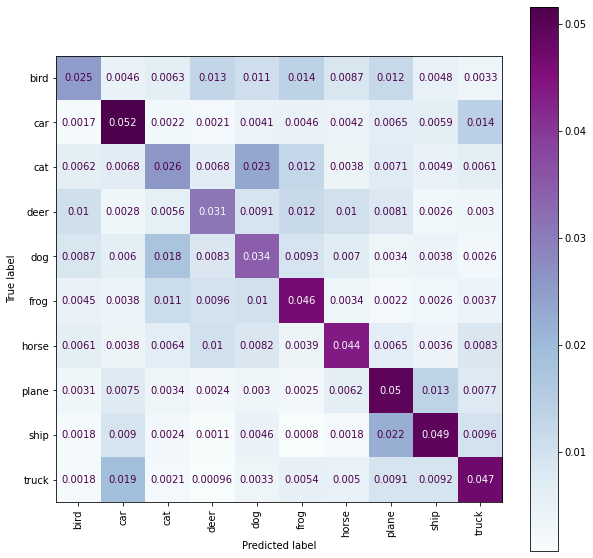

In [7]:
plot_confusion_matrix(y_true=y_val, y_pred=y_val_hat)

Grundsätzlich machen wir noch einige Fehler. Wir stellen fest, dass die Verteilung-Fehler aber intuitive Sinn ergibt.

Schauen wir uns nun an, was passiert, wenn wir den Parameter `max_iter` erhöhen.
Im folgenden Code setzen wir die `max_iter=1000`:

In [8]:
%%time

lr_1k = LogisticRegression(max_iter=1000)
lr_1k.fit(X_train.reshape(-1, 32 * 32 * 3), y_train)

y_train_hat = lr_1k.predict(X_train.reshape(-1, 32 * 32 * 3))
print("Train: ", accuracy_score(y_train_hat, y_train))

y_val_hat = lr_1k.predict(X_val.reshape(-1, 32 * 32 * 3))
print("Val:   ", accuracy_score(y_val_hat, y_val))

/Users/beni/Documents/Kennwerte/IdeaProjects/cas_machine_learning_cifar10/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train:  0.4988533333333333
Val:    0.36928
CPU times: user 38min 50s, sys: 3min 59s, total: 42min 49s
Wall time: 6min 23s


Wir sehen, dass wir uns auf dem `Training Set` verbessern, aber anfangen uns auf dem `Validation Set` zu verschlechtern, ein Hinweis auf `Overfitting`.
Zudem sind wir immer noch nicht konvergiert, sprich müssten `max_iter` weiter erhöhen.

Nächste mögliche Schritte wären die `max_iter` zu erhöhen bis wir konvergieren und gleichzeitig die `Regularisierung` zu erhöhen (`C` verkleinern) gegen das `Overfitting`.

Oder die Art vom Modell gänzlich zu verändern und die jetzige `Logistische Regression` als `Baseline` zu verwenden.
Beispielsweise kann man das Problem mit dem Konvertieren auch mit einer Unsupervised Dimensionsreduktion wie `PCA` angehen.

# (Extra) Logistic Regression with saga

Man kann bei Logistic Regression den Lern-Algorithmus mittels dem `solver` Parameter verändern.
Default ist dieser auf `lbfgs` eingestellt, ein Verfahren das über die zweite Ableitung lernt (im Theorie Teil nicht angeschaut).
Man kann den `solver` auch auf `saga` einstellen, was mehr oder weniger dem Stochastic Gradient Descent entspricht vom Theorie Teil.
`saga` ist grundsätzlich für grosse Datensätze (ab ~100'000 Zeilen) schneller im konvergieren.
Hier ist `saga` aber nicht wirklich schneller.
Zudem kann man im sklearn nur wenig für die Stochastic Gradient Descent einstellen: Es fehlen Parameter für die Batch Size und Momentum.

In [9]:
%%time

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

lr_saga = Pipeline([
    ('std', StandardScaler()), # Für saga müssen wir die Inputs zuerst standartisieren
    ('clf', LogisticRegression(solver='saga'))
])

lr_saga.fit(X_train.reshape(-1, 32 * 32 * 3), y_train)

y_train_hat = lr.predict(X_train.reshape(-1, 32 * 32 * 3))
print("Train: ", accuracy_score(y_train_hat, y_train))

y_val_hat = lr.predict(X_val.reshape(-1, 32 * 32 * 3))
print("Val:   ", accuracy_score(y_val_hat, y_val))

/Users/beni/Documents/Kennwerte/IdeaProjects/cas_machine_learning_cifar10/venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Train:  0.4294133333333333
Val:    0.4044
CPU times: user 7min 15s, sys: 3.7 s, total: 7min 19s
Wall time: 7min 19s


# Predict classes for test set

If we are happy with the performance of our model on the validation set, we can apply it to the test set.

In [10]:
with open('../data/test.pkl', 'rb') as f:
    X_test = pickle.load(f)

In [11]:
y_test_pred = lr.predict(X_test.reshape(-1, 32 * 32 * 3))
y_test_pred_df = pd.DataFrame(y_test_pred, columns=['label'])

To submit the predictions to Kaggle we write them into a .csv file, which you can manually submit.

In [12]:
y_test_pred_df.to_csv('../out/logistic_regression.csv', header=True, index_label='id')